In [23]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import shuffle

In [28]:
TRAIN_DIR = '/kaggle/input/facial-keypoints/training.csv'
TEST_DIR = '/kaggle/input/facial-keypoints/test.csv'
LOOK_ID_DIR = '/kaggle/input/facial-keypoints-detection/IdLookupTable.csv'

TRAIN_DATA = pd.read_csv(TRAIN_DIR)  
TEST_DATA = pd.read_csv(TEST_DIR)
LOOK_ID_DATA = pd.read_csv(LOOK_ID_DIR)

In [27]:
print(TRAIN_DATA.shape)
print(TEST_DATA.shape)

(7049, 31)
(1783, 2)


In [16]:
TRAIN_DATA.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,[]
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,[]
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,[]
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,[]
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,[]


In [20]:
TRAIN_DATA['Image'] = TRAIN_DATA['Image'].apply(lambda im: np.fromstring(im, sep=' '))
TRAIN_DATA.dropna(inplace=True)
TRAIN_DATA.isnull().any().value_counts()

False    31
Name: count, dtype: int64

In [54]:
def load_data(dirname, test=False):
    data = pd.read_csv(dirname)

    if not test:
        data = data.dropna()

    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' '))
    
    imgs = np.vstack(data['Image'].values) / 255.0
    imgs = imgs.reshape(-1, 96, 96, 1).astype(np.float32)

    if not test:
        points = data[data.columns[:-1]].values
        points = (points - 48) / 48.0 
        points = points.astype(np.float32)
        imgs, points = shuffle(imgs, points, random_state=42)
        return imgs, points
    
    else:
        return imgs

X_train, y_train = load_data(TRAIN_DIR)
X_test = load_data(TEST_DIR, test=True)

In [55]:
X_train.shape, y_train.shape

((2140, 96, 96, 1), (2140, 30))

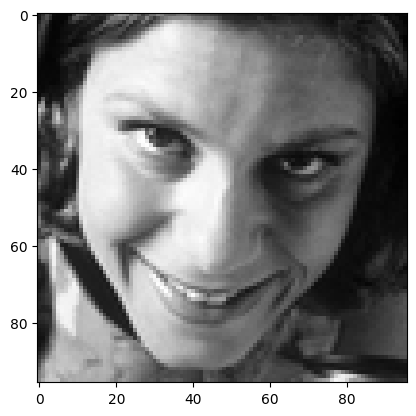

In [56]:
plt.imshow(np.squeeze(X_train[1]), cmap='gray')

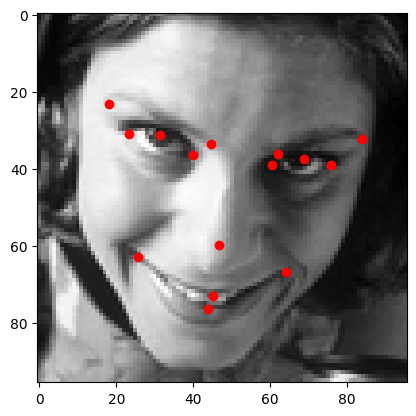

In [65]:
def plotKeyPoints(img, points):
    plt.imshow(img,cmap='gray')

    for i in range(0,30,2):
        plt.scatter((points[i] + 1) * 48, (points[i+1] + 1) * 48, color='red')


        
plotKeyPoints(X_train[1],y_train[1])

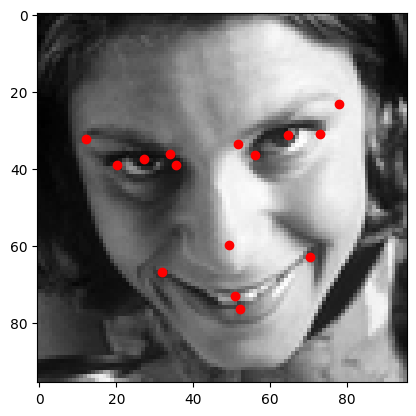

In [66]:
def augment_data(img, points):
    new_img = np.fliplr(img)
    new_points = np.copy(points)
    new_points[::2] = -new_points[::2]
    return new_img, new_points

flip_img, flip_points = augment_data(X_train[1], y_train[1])
plotKeyPoints(flip_img, flip_points)

In [67]:
final_X_train = []
final_y_train = []

# apply flipping operation to each example in the training set
for i in range(0,X_train.shape[0]):
    aug_img, aug_point = augment_data(X_train[i], y_train[i])
     # append the original data first
    final_X_train.append(X_train[i])
    final_y_train.append(y_train[i]) 
    
    # then the augmented data
    final_X_train.append(aug_img)
    final_y_train.append(aug_point) 

# convert to numpy
final_X_train = np.array(final_X_train)   
final_y_train = np.copy(final_y_train)

print(final_X_train.shape)
print(final_y_train.shape)

(4280, 96, 96, 1)
(4280, 30)


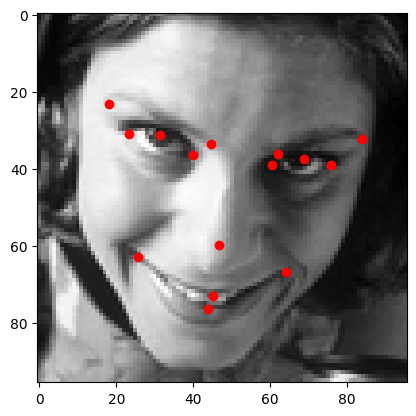

In [68]:
plotKeyPoints(final_X_train[2], final_y_train[2])

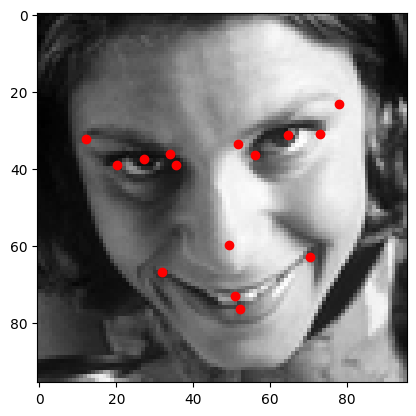

In [69]:
plotKeyPoints(final_X_train[3], final_y_train[3])

In [73]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, History
from keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import MeanAbsoluteError

In [71]:
final_X_train = final_X_train.reshape(final_X_train.shape[0], 96, 96, 1)

In [83]:
model = Sequential([
    Conv2D(16, 3, activation='relu', input_shape=(96, 96, 1)),
    # BatchNormalization(),
    MaxPooling2D(2),
    
    Conv2D(32, 3, activation='relu'),
    # BatchNormalization(),
    MaxPooling2D(2),
    
    Conv2D(64, 3, activation='relu'),
    # BatchNormalization(),
    MaxPooling2D(2),
    
    Conv2D(128, 3, activation='relu'),
    # BatchNormalization(),
    MaxPooling2D(2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    # BatchNormalization(),
    
    Dense(512, activation='relu'),
    Dropout(0.2),
    # BatchNormalization(),
    
    Dense(30, activation='tanh')  
])

model.compile(loss='mse', optimizer='adam', metrics=[MeanAbsoluteError()])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 94, 94, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 47, 47, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 20, 20, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 30)                  │          15,390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,424,286 (5.43 MB)

 Trainable params: 1,424,286 (5.43 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
checkpoint = ModelCheckpoint(
    'best_model_full.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False
)


callbacks = [checkpoint]

hist = model.fit(
    final_X_train,
    final_y_train,
    validation_split=0.2,
    batch_size=64,
    shuffle=True,
    epochs=150,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0959 - mean_absolute_error: 0.2340
Epoch 1: val_loss improved from inf to 0.07633, saving model to best_model_full.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.0957 - mean_absolute_error: 0.2336 - val_loss: 0.0763 - val_mean_absolute_error: 0.1871
Epoch 2/150
50/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0756 - mean_absolute_error: 0.1890
Epoch 2: val_loss improved from 0.07633 to 0.07512, saving model to best_model_full.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0756 - mean_absolute_error: 0.1889 - val_loss: 0.0751 - val_mean_absolute_error: 0.1854
Epoch 3/150
50/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0721 - mean_absolute_error: 0.1828
Epoch 3: val_loss improved from 0.07512 to 0.06234, saving model to best_model_full.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0718 - mean_absolute_error: 0.1824 - val_loss: 0.0623 - val_mean_absolute_error: 0.1632
Epoch 4/150
50/54 ━━━━━━━━━━━━━━━━━━━━ 0

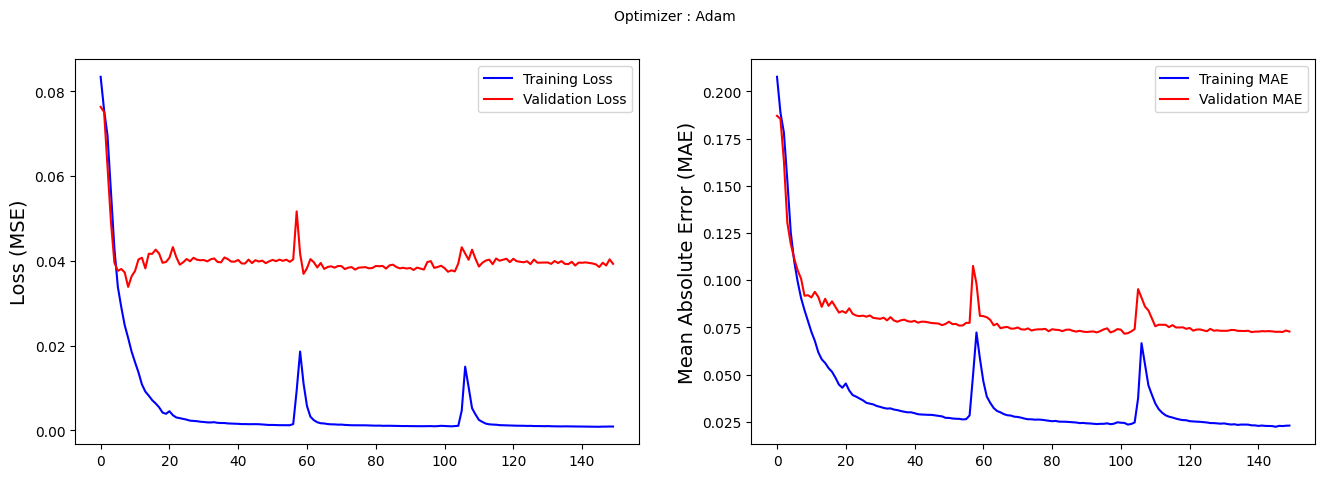

In [85]:
plt.figure(figsize=(16, 5))

# Loss Plot (MSE)
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# MAE Plot
plt.subplot(1, 2, 2)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
plt.plot(hist.history['mean_absolute_error'], color='b', label='Training MAE')
plt.plot(hist.history['val_mean_absolute_error'], color='r', label='Validation MAE')
plt.legend(loc='upper right')

plt.show()


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


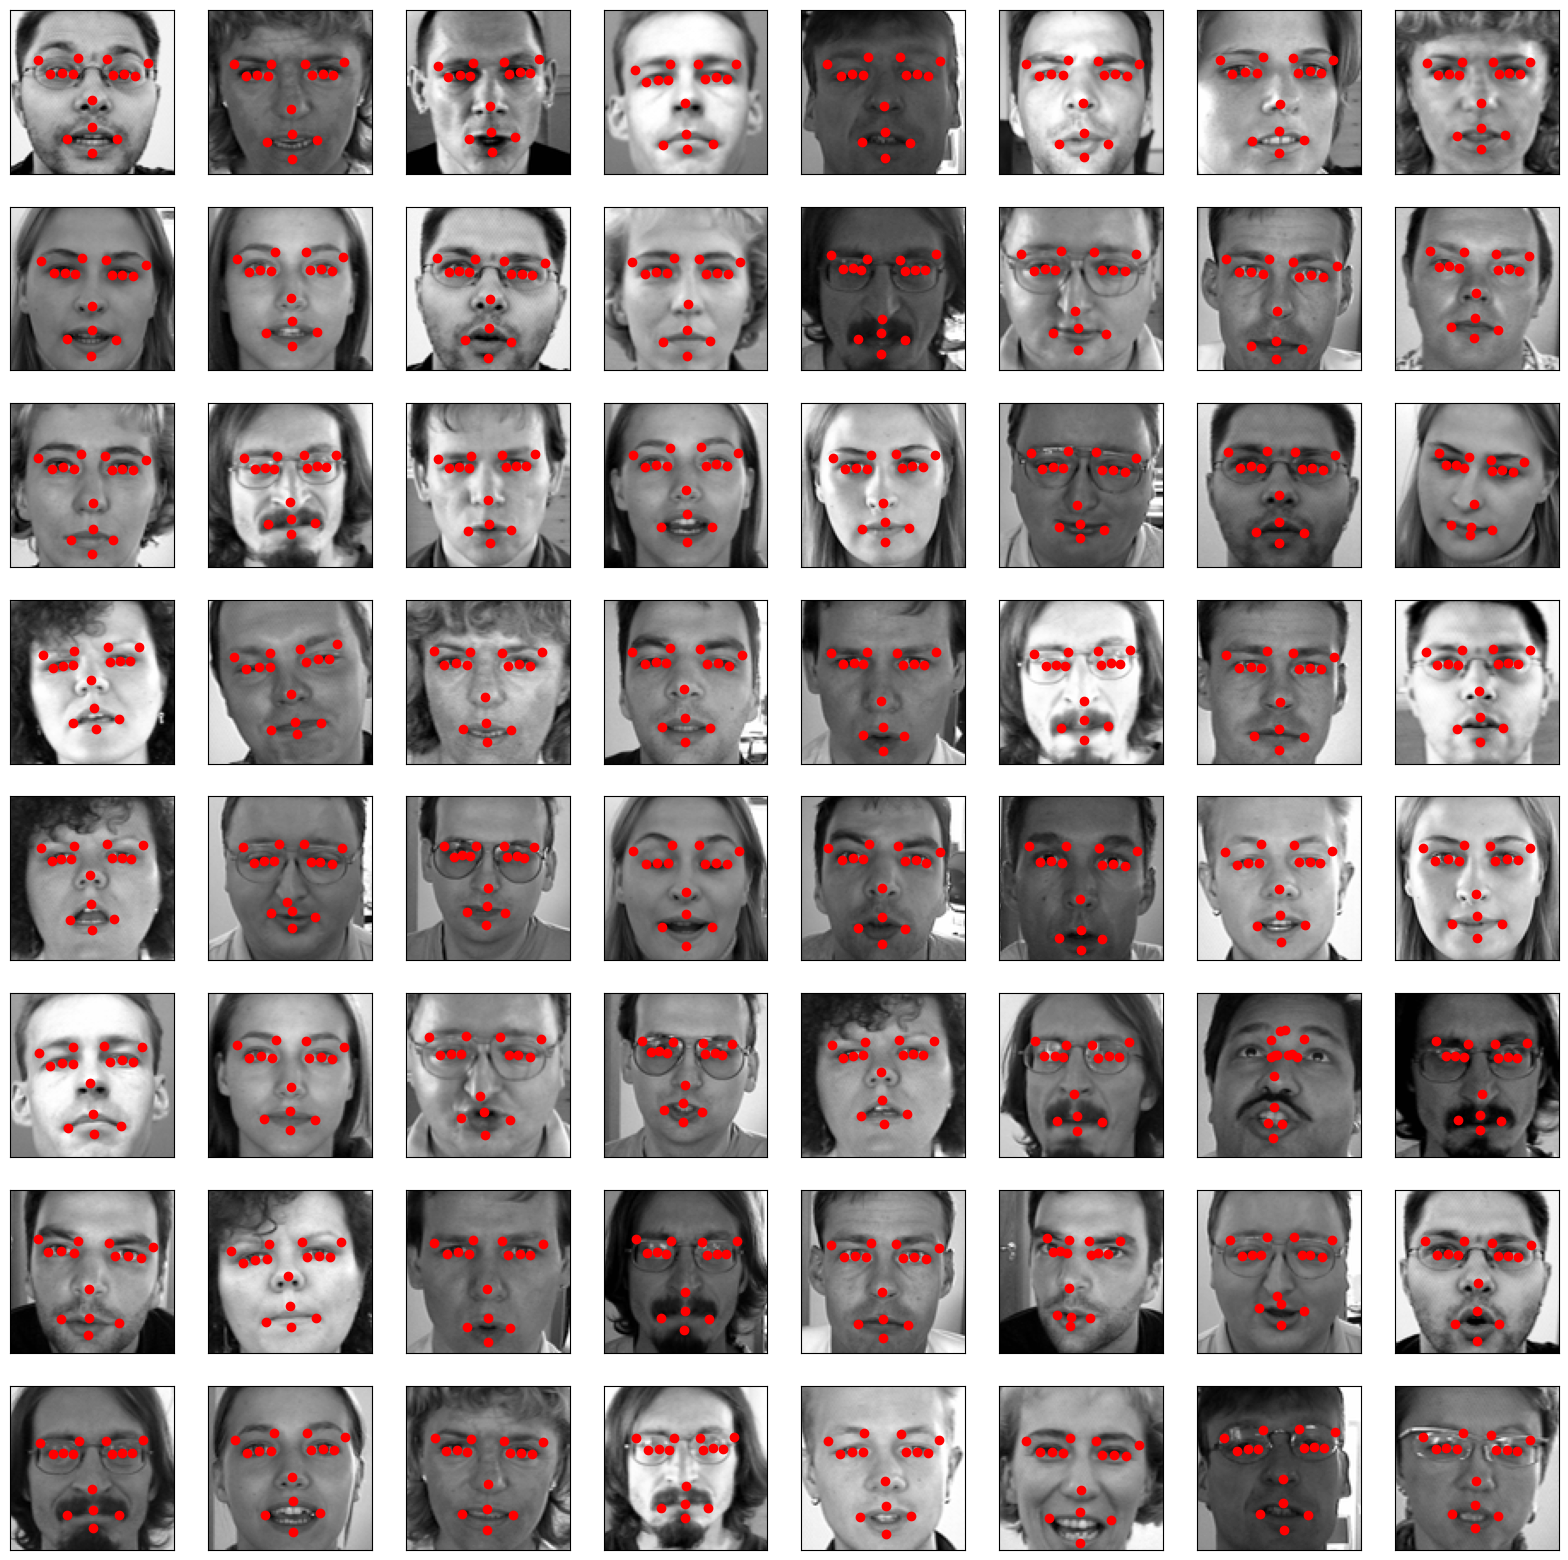

In [90]:
fig = plt.figure(figsize=(20,20))
# make test images keypoints prediction
points_test = model.predict(X_test.reshape(X_test.shape[0], 96, 96, 1))

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    plotKeyPoints(X_test[i], np.squeeze(points_test[i]))